# TEXT MINING PROJECT: Amazon Reviews Analysis

#### Authors:
- Federico Signoretta - 847343 - f.signoretta@campus.unimib.it
- Davide Sangalli - 848013 - d.sangalli5@campus.unimib.it
- Diana Tenca - 789651- d.tenca@campus.unimib.it

## Import dei pacchetti necessari

In [0]:
import pandas as pd
import numpy as np

import gzip
import json
import joblib
import os
import re
import unicodedata

from textblob import TextBlob
from textblob import Word


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from matplotlib import pyplot as plt

import warnings
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Embedding, LSTM, GRU, Conv1D, AveragePooling1D, Flatten, MaxPooling1D

import sklearn
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.cluster import KMeans,DBSCAN
from sklearn import metrics

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


import os, logging

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)

import tensorflow as tf
import tensorflow_hub as hub

print(tf.contrib.util.constant_value(tf.ones([1])))

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[1.]


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#funzioni necessarie per importare e leggere i dati 

def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [0]:
#caricamento dei dataframes dalla directory
path = '/content/drive/My Drive/Text Mining Project/data/'
df_list = []
for label in os.listdir(path):
  x = label[:3].lower()
  df_list.append(label[:-10])
  globals()['df_' + str(x)] = getDF(path + label)

In [0]:
df_list

['Video_Games',
 'Patio_Lawn_and_Garden',
 'Office_Products',
 'Arts_Crafts_and_Sewing',
 'Musical_Instruments',
 'Digital_Music',
 'Prime_Pantry',
 'Industrial_and_Scientific']

In [0]:
df_all = [df_vid, df_pat, df_ind, df_pri, 
          df_dig, df_mus, df_art, df_off] 

In [0]:
df_count = []
for i in df_all:
  df_count.append(len(i))

In [0]:
#creazione di una nuova colonna con le categorie
i = 0
for d in df_all:
    d['category'] = i
    i += 1

In [0]:
#creazione una nuova colonna col giudizio positivo/negativo (0,1)
for d in df_all:
  d["is_good"] = d["overall"].apply(lambda x: 1 if x > 4 else 0)

In [0]:
#unione dei dataframes

df_reviews = pd.concat(df_all)
df_reviews = df_reviews.reset_index().drop('index', axis=1)

len(df_reviews)

3206866

In [0]:
df_reviews.columns 

Index(['asin', 'category', 'image', 'is_good', 'overall', 'reviewText',
       'reviewTime', 'reviewerID', 'reviewerName', 'style', 'summary',
       'unixReviewTime', 'verified', 'vote'],
      dtype='object')

In [0]:
df = df_reviews[['reviewText','category','is_good']]

del df_all, df_reviews

In [0]:
del df_vid, df_pat, df_ind, df_pri, df_dig, df_mus, df_art, df_off

In [0]:
#dump del dataframe unito
joblib.dump(df, '/content/drive/My Drive/Text Mining Project/df_amz_all.joblib')

['/content/drive/My Drive/Text Mining Project/df_amz_all.joblib']

In [0]:
# saltando i passsaggi precedenti è possibile partire dal seguente dump
df = joblib.load('/content/drive/My Drive/Text Mining Project/dumps&images/df_amz_all.joblib')

# applicazione di uno shuffle ai dati
df = shuffle(df)

In [0]:
# codice utile nel caso si volesse effettuare undersampling basandosi sulla categoria minoritaria -- in questo caso non è stato fatto undersampling

'''from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
min_class = len(train[train.category==5])
min_class

for i in range(0,13):
  globals()['df_' + str(i)] =  train[train.category==i].sample(n = min_class)
train_under = pd.concat([df_0,df_1, df_2, df_3, df_4, df_5, df_6,
                         df_7, df_8, df_9, df_10, df_11, df_12])'''

"from collections import Counter\nfrom sklearn.datasets import make_classification\nfrom imblearn.over_sampling import RandomOverSampler\nmin_class = len(train[train.category==5])\nmin_class\n\nfor i in range(0,13):\n  globals()['df_' + str(i)] =  train[train.category==i].sample(n = min_class)\ntrain_under = pd.concat([df_0,df_1, df_2, df_3, df_4, df_5, df_6,\n                         df_7, df_8, df_9, df_10, df_11, df_12])"

## Pre-Processing
- Tokenization
- Normalization
- Lemmatization
- Stop-words removal
- Addictional

In [0]:

# replace delle abbreviazioni
def replace_words(data_text):
  data_text = data_text.str.lower()
  data_text = data_text.replace('\n','', regex=True).\
                                      replace('won\'t','will not', regex=True).\
                                      replace('n\'t',' not', regex=True).\
                                      replace('\'d',' would', regex=True).\
                                      replace('\'s',' is', regex=True).\
                                      replace('\'m',' am', regex=True).\
                                      replace('\'ll',' will', regex=True).\
                                      replace('\'ve',' have', regex=True).\
                                      replace('\'re',' are', regex=True).\
                                      replace('ying','y', regex=True)
  
  return data_text


# rimozione degli accenti (e.g. à -> a)
def remove_accents(input_str):
  nfkd_form = unicodedata.normalize('NFKD', str(input_str))
  return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])


# rimozione duplicati e nulli
def drop_nan_dup(data):
  data.reviewText.replace('NaN', np.nan, regex=True).dropna(inplace=True)
  data.drop_duplicates(inplace=True)
  data.dropna(inplace=True)
  print(len(data))

# rimozione di caratteri numerici e punteggiatura
def remove_num_symb(data):
  data = data.replace('[^\w\s]','', regex=True).\
              replace('\.',' ', regex=True).\
              replace('\d+','', regex=True)
  return data

In [0]:
# vengono estese le forme contratte
df['reviewText'] = replace_words(df['reviewText'])

# vengono rimpizzate le lettere con gli accenti, con quelle senza accenti
df['reviewText'] = df['reviewText'].apply(remove_accents)

# vengono rimosse le istanze nulle e i duplicati
drop_nan_dup(df)
df.reviewText.isna().sum()


# vengono rimossi i simboli, punteggiatura e numeri
df.reviewText = remove_num_symb(df.reviewText)

2418725


In [0]:
joblib.dump(df, '/content/drive/My Drive/Text Mining Project/dumps&images/df_cluster.joblib')

['/content/drive/My Drive/Text Mining Project/df_cluster.joblib']

In [0]:
df['reviewText']

2907014    it is definitely worth it to buy the xl versio...
1634553    for the last few years i have slowly gone back...
293011     the zipper keeps breaking i have tried to fix ...
227027                                           works great
2719103    nice little cap works well fast shipping from ...
                                 ...                        
2597484    if you are buy this to use the fancy style f b...
1898248                         did what i needed them to do
3134531    this fits perfectly on my desk and holds every...
841382     a ferule and a couple of hoseclamps is about t...
440789     watch dogs  is a huge improvement over the fir...
Name: reviewText, Length: 2418725, dtype: object

#### Tokanization e Lemmatization

In [0]:
tok_ = nltk.tokenize.WhitespaceTokenizer()
lemm_ = nltk.stem.WordNetLemmatizer()

def lemmatize_text_verb(text):
    return [lemm_.lemmatize(w,'v') for w in tok_.tokenize(text)]
def lemmatize_text_adj(text):
    return [lemm_.lemmatize(w, 'a') for w in text]
def lemmatize_text(text):
    return [lemm_.lemmatize(w) for w in text]

df.reviewText = df.reviewText.apply(lemmatize_text_verb).apply(lemmatize_text_adj).apply(lemmatize_text)

In [0]:
def tokeniz(text):
    return [w for w in tok_.tokenize(text)]

In [0]:
# viene creato un nuovo dataframe per dedicato alla risoluzione del task di classificazione (positivo/negativo)
df_rating = df.copy()


# viene unita la negazione alla parola successiva (e.g. not useful --> not_useful)
df_rating['reviewText'] = df_rating['reviewText'].replace('not\s','not_',regex=True).\
                                              replace('nor\s','nor_',regex=True).\
                                              replace('no\s','no_',regex=True).\
                                              replace('neither\s','neither_',regex=True)  
  
df_rating['reviewText']= df_rating['reviewText'].astype(str)                                                            
df_rating.reviewText = df_rating.reviewText.apply(tokeniz)

In [0]:
# vengono rimosse le stop words 
stop = stopwords.words('english')

df.reviewText = df.reviewText.apply(lambda x: [item for item in x if item not in stop])
df_rating.reviewText = df_rating.reviewText.apply(lambda x: [item for item in x if item not in stop])

In [0]:
def join_terms(sentence):
  sentence = ' '.join(sentence)
  return sentence

In [0]:
# vengono ricreate le frasi e creati dei dump
df.reviewText = df.reviewText.apply(join_terms)
df_rating.reviewText = df_rating.reviewText.apply(join_terms)

joblib.dump(df, '/content/drive/My Drive/Text Mining Project/dumps&images/df_category.joblib')
joblib.dump(df_rating, '/content/drive/My Drive/Text Mining Project/dumps&images/df_rating.joblib')

In [0]:
# IMPORT DEI DATI DA DUMP: serve per evitare di rieseguire le operazioni precedenti, le quali richiedono tempo

# dati "puliti" per categories
df_category = joblib.load('/content/drive/My Drive/Text Mining Project/dumps&images/df_category.joblib')

# dati "puliti" per rating
df_rating = joblib.load('/content/drive/My Drive/Text Mining Project/dumps&images/df_rating.joblib')

In [0]:
category_count = pd.DataFrame(df_category.groupby(['category'])['reviewText'].count()).reset_index()
category_count['Categories'] = ['Video_Games','Patio_Lawn_and_Garden','Office_Products','Arts_Crafts_and_Sewing',
                          'Musical_Instruments','Digital_Music','Prime_Pantry','Industrial_and_Scientific']
category_count['freq_perc'] = df_category['category'].value_counts(normalize =True)*100
category_count = category_count[['Categories','reviewText','freq_perc']]
category_count.columns=['Categories', 'Number of Reviews','freq_perc']
category_count = category_count.sort_values(by='Number of Reviews',ascending=False)

category_count

In [0]:
ax = sns.barplot(y="Categories", x="Number of Reviews", data=category_count,palette="Blues_d")
plt.xticks(rotation=45)

plt.show()
plt.draw()

plt.savefig('/content/drive/My Drive/Text Mining Project/dumps&images/count_categories.png')

In [0]:
rating_count = pd.DataFrame(df_rating.groupby(['is_good'])['reviewText'].count()).reset_index()
rating_count['is_good'] = ['negative','positive']
rating_count['freq_perc'] = df_rating['is_good'].value_counts(normalize =True)*100
rating_count = rating_count[['is_good','reviewText','freq_perc']]
rating_count.columns=['Class', 'Number of Reviews','freq_perc']
rating_count = rating_count.sort_values(by='Number of Reviews',ascending=False)

rating_count

In [0]:
ax = sns.barplot(x="Class", y="Number of Reviews", data=rating_count,palette="Blues_d")
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/len(df_rating)),
            ha="center")
plt.show()
plt.draw()
    
plt.savefig('/content/drive/My Drive/Text Mining Project/dumps&images/count_class.png')

In [0]:
# Splitting in training e test set 

# TRAINING SET: 75%
# TEST SET: 15%

train_category, test_category = train_test_split(df_category, test_size = 0.15, random_state=1)
train_rating, test_rating = train_test_split(df_rating, test_size = 0.15, random_state=1)

#### WordChart

In [0]:
mask = np.array(Image.open('/content/drive/My Drive/Text Mining Project/dumps&images/amazon.png'))

train_s = shuffle(train_category.copy())
wordcloud = WordCloud(background_color="white", max_words=1000, mask=mask).generate(train_s[:200000].sum()[0])

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,13])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

wordcloud.to_file("/content/drive/My Drive/Text Mining Project/dumps&images/word_chart.png")

### Text representeation: word embedding


In [0]:
def tokenization(data):
  tokenizer = Tokenizer(num_words=100000)
  tokenizer.fit_on_texts(data['reviewText'].values)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  return tokenizer
  
def word_emb_seq(data, tokenizer):
    X = tokenizer.texts_to_sequences(data['reviewText'].values)
    X = pad_sequences(X, maxlen=100)
    print('Shape of data tensor:', X.shape)
    return X

In [0]:
# creazione del target per il train e il test e trasformata col metodo one-hot-encoding

train_label_category = train_category.category
test_label_category = test_category.category

train_label_category = to_categorical(train_label_category, num_classes=8)
test_label_category = to_categorical(test_label_category, num_classes=8)

In [0]:
# tokanization del train e del test

%time tok_train_category = tokenization(train_category)
%time tok_test_category = tokenization(test_category)

Found 967933 unique tokens.
CPU times: user 59.8 s, sys: 285 ms, total: 1min
Wall time: 1min
Found 271759 unique tokens.
CPU times: user 10.2 s, sys: 63.3 ms, total: 10.3 s
Wall time: 10.3 s


In [0]:
# word embedding sul train e sul test

%time train_we_category = word_emb_seq(train_category, tok_train_category)
%time test_we_category = word_emb_seq(test_category, tok_train_category)

Shape of data tensor: (2055916, 100)
CPU times: user 59.6 s, sys: 491 ms, total: 1min
Wall time: 1min
Shape of data tensor: (362809, 100)
CPU times: user 10.5 s, sys: 78.8 ms, total: 10.6 s
Wall time: 10.6 s


In [0]:
# codice per utilizzare reti pre-trainate
# load the whole embedding into memory
'''embeddings_index = dict()
f = open('/content/drive/My Drive/Text Mining Project/glove.6B.100d.txt')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((1006557, 100))

for word, i in tok_train.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector'''

### Classificazione attraverso Recurrent Neural Network (LSTM)

In [0]:
#definizione della Recurrent Neural Network di tipo LSTM

def rnn_model():
  model = Sequential()
  model.add(Embedding(100000, 100, input_length=train_we_category.shape[1]))
  model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5)) # hidden layer di 128 unità - activation function: 'relu' - recurrent activation function: 'tanh'
  model.add(Dense(8, activation='softmax')) #layer di output di 8 unità (pari al numero di classi) con funzione di attivazione 'softmax'

  model.summary()

  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [0]:
model_category = rnn_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          10000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 10,118,280
Trainable params: 10,118,280
Non-trainable params: 0
_________________________________________________________________


In [0]:
#---------------------------------------------------------------------------------------------------------------------
# codice per generare batch bilanciati all'interno della rete durante la fase di training
# non viene utilizzato poiché computazionalmente troppo oneroso

#from imblearn.keras import BalancedBatchGenerator
#from imblearn.under_sampling import NearMiss
#training_generator = BalancedBatchGenerator(train_we, train_label.argmax(axis = -1),sampler=NearMiss(), batch_size=2048)

#--------------------------------------------------------------------------------------------------------------------

In [0]:
#definizone dei pesi delle classi
class_weights = sklearn.utils.class_weight.compute_sample_weight(class_weight='balanced', y=train_label_category)

#fitting della rete 
#network_history = model.fit(generator = training_generator, epochs=5, validation_data=(test_we, test_label), verbose=1)


#fitting della rete 
%time network_history_category = model_category.fit(train_we_category, \
                                                    train_label_category, \
                                                    epochs=6, batch_size=2048, \
                                                    class_weight=class_weights, \
                                                    validation_data=(test_we_category, test_label_category))

Train on 2055916 samples, validate on 362809 samples
Epoch 1/6
2055916/2055916 [==============================] - 205s 100us/step - loss: 0.7126 - acc: 0.7514 - val_loss: 0.5225 - val_acc: 0.8140
Epoch 2/6
2055916/2055916 [==============================] - 203s 99us/step - loss: 0.5167 - acc: 0.8157 - val_loss: 0.4999 - val_acc: 0.8194
Epoch 3/6
2055916/2055916 [==============================] - 203s 99us/step - loss: 0.4923 - acc: 0.8229 - val_loss: 0.4932 - val_acc: 0.8215
Epoch 4/6
2055916/2055916 [==============================] - 202s 98us/step - loss: 0.4779 - acc: 0.8273 - val_loss: 0.4893 - val_acc: 0.8225
Epoch 5/6
2055916/2055916 [==============================] - 203s 99us/step - loss: 0.4681 - acc: 0.8304 - val_loss: 0.4897 - val_acc: 0.8228
Epoch 6/6
2055916/2055916 [==============================] - 203s 99us/step - loss: 0.4598 - acc: 0.8330 - val_loss: 0.4887 - val_acc: 0.8233
CPU times: user 28min 58s, sys: 5min 5s, total: 34min 4s
Wall time: 20min 19s


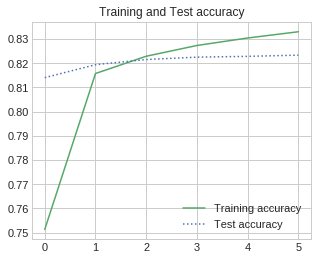

In [0]:
#plot dell'accuracy su train e test
epoch = network_history_category.epoch

plt.style.use('seaborn-whitegrid')
loss = network_history_category.history['acc']
val_loss = network_history_category.history['val_acc']
 
plt.figure(figsize=(5,4))
plt.plot(epoch, loss, 'g', label='Training accuracy')
plt.plot(epoch, val_loss, 'b:', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.legend()
plt.show()


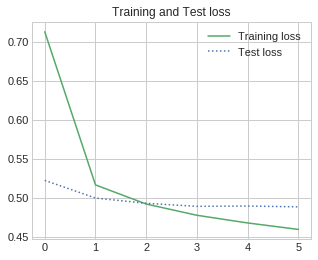

In [0]:
#plot della loss function sul train e test
plt.style.use('seaborn-whitegrid')
loss = network_history_category.history['loss']
val_loss = network_history_category.history['val_loss']
 
plt.figure(figsize=(5,4))
plt.plot(epoch, loss, 'g', label='Training loss')
plt.plot(epoch, val_loss, 'b:', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

In [0]:
#metrics on test set
%time y_preds = model_category.predict_classes(test_we_category)
y_test_ = [np.argmax(y, axis=None, out=None) for y in test_label_category]

target_names = ['Video_Games','Patio_Lawn_and_Garden','Office_Products','Arts_Crafts_and_Sewing',
                'Musical_Instruments','Digital_Music','Prime_Pantry','Industrial_and_Scientific']
print(classification_report(y_test_, y_preds, target_names=target_names))

CPU times: user 15min 29s, sys: 2min 26s, total: 17min 55s
Wall time: 9min 40s
                           precision    recall  f1-score   support

              Video_Games       0.94      0.91      0.92     60054
    Patio_Lawn_and_Garden       0.82      0.87      0.84     95987
          Office_Products       0.71      0.40      0.51      8652
   Arts_Crafts_and_Sewing       0.85      0.76      0.80     14702
      Musical_Instruments       0.94      0.89      0.91     13993
            Digital_Music       0.90      0.79      0.84     28320
             Prime_Pantry       0.73      0.74      0.74     52519
Industrial_and_Scientific       0.77      0.82      0.80     88582

                 accuracy                           0.82    362809
                macro avg       0.83      0.77      0.80    362809
             weighted avg       0.82      0.82      0.82    362809



In [0]:
#metrics on training set
y_preds_train = model_category.predict_classes(train_we_category)
y_train_ = [np.argmax(y, axis=None, out=None) for y in train_label_category]
#y_preds = [x.argmax() for x in y_preds]

print(classification_report(y_train_, y_preds_train, target_names=target_names))

In [0]:
'''# serialize model to YAML
model_yaml = model.to_yaml()
with open("RNN_weights.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Text Mining Project/dumps&images/RNN_weights.h5")
print("Saved model to disk")'''

# Calssificazione classe Positiva/Negativa

In [0]:
# codice utile per fare undersampling 
'''from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

min_class = len(train_rating[train_rating.is_good==0])
min_class

for i in range(0,2):
  globals()['df_' + str(i)] =  train_rating[train_rating.is_good==i].sample(n = min_class)

train_under = pd.concat([df_0,df_1])'''

In [0]:
%time tok_train_rating = tokenization(train_rating)
%time tok_test_rating = tokenization(test_rating)

Found 965560 unique tokens.
CPU times: user 57.7 s, sys: 0 ns, total: 57.7 s
Wall time: 57.7 s
Found 275054 unique tokens.
CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 10.4 s


In [0]:
%time train_we_rating = word_emb_seq(train_rating, tok_train_rating)
%time test_we_rating = word_emb_seq(test_rating, tok_train_rating)

Shape of data tensor: (2055916, 100)
CPU times: user 59.5 s, sys: 0 ns, total: 59.5 s
Wall time: 59.5 s
Shape of data tensor: (362809, 100)
CPU times: user 9.43 s, sys: 0 ns, total: 9.43 s
Wall time: 9.43 s


In [0]:
train_label_rating = train_rating.is_good
test_label_rating = test_rating.is_good

train_label_rating = to_categorical(train_label_rating, num_classes=2)
test_label_rating = to_categorical(test_label_rating, num_classes=2)

In [0]:
def rnn_model_():
  model = Sequential()
  model.add(Embedding(100000, 100, input_length=train_we_rating.shape[1]))
  model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
  model.add(Dense(2, activation='sigmoid'))

  model.summary()

  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
model_rating = rnn_model_()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          10000000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 10,117,506
Trainable params: 10,117,506
Non-trainable params: 0
_________________________________________________________________


In [0]:
class_weights = sklearn.utils.class_weight.compute_sample_weight(class_weight='balanced', y=train_label_rating)

%time network_history_rating = model_rating.fit(train_we_rating,\
                                                train_label_rating, \
                                                epochs=6, batch_size=2048, \
                                                validation_data=(test_we_rating, test_label_rating),class_weight=class_weights)

Train on 2055916 samples, validate on 362809 samples
Epoch 1/6
2055916/2055916 [==============================] - 203s 99us/step - loss: 0.4639 - acc: 0.7872 - val_loss: 0.4318 - val_acc: 0.8070
Epoch 2/6
2055916/2055916 [==============================] - 202s 98us/step - loss: 0.4247 - acc: 0.8110 - val_loss: 0.4185 - val_acc: 0.8139
Epoch 3/6
2055916/2055916 [==============================] - 201s 98us/step - loss: 0.4077 - acc: 0.8208 - val_loss: 0.4103 - val_acc: 0.8199
Epoch 4/6
2055916/2055916 [==============================] - 201s 98us/step - loss: 0.3955 - acc: 0.8275 - val_loss: 0.4098 - val_acc: 0.8209
Epoch 5/6
2055916/2055916 [==============================] - 201s 98us/step - loss: 0.3864 - acc: 0.8325 - val_loss: 0.4078 - val_acc: 0.8225
Epoch 6/6
2055916/2055916 [==============================] - 201s 98us/step - loss: 0.3784 - acc: 0.8369 - val_loss: 0.4099 - val_acc: 0.8230
CPU times: user 28min 22s, sys: 4min 58s, total: 33min 21s
Wall time: 20min 10s


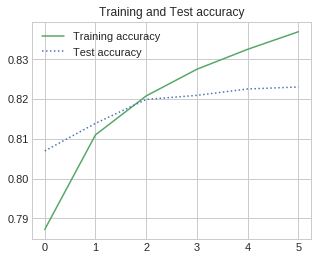

In [0]:
epoch = network_history_rating.epoch

plt.style.use('seaborn-whitegrid')
loss = network_history_rating.history['acc']
val_loss = network_history_rating.history['val_acc']
 
plt.figure(figsize=(5,4))
plt.plot(epoch, loss, 'g', label='Training accuracy')
plt.plot(epoch, val_loss, 'b:', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.legend()
plt.show()

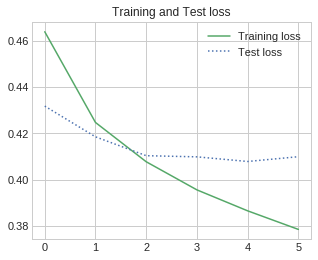

In [0]:
plt.style.use('seaborn-whitegrid')
loss = network_history_rating.history['loss']
val_loss = network_history_rating.history['val_loss']
 
plt.figure(figsize=(5,4))
plt.plot(epoch, loss, 'g', label='Training loss')
plt.plot(epoch, val_loss, 'b:', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

In [0]:
#metrics on validation set
%time y_preds = model_rating.predict_classes(test_we_rating)
y_test_ = [np.argmax(y, axis=None, out=None) for y in test_label_rating]

target_names = ['negative','positive']
print(classification_report(y_test_, y_preds, target_names=target_names)) #70,87--best

CPU times: user 15min 10s, sys: 2min 23s, total: 17min 33s
Wall time: 9min 29s
              precision    recall  f1-score   support

    negative       0.79      0.64      0.71    121433
    positive       0.84      0.91      0.87    241376

    accuracy                           0.82    362809
   macro avg       0.81      0.78      0.79    362809
weighted avg       0.82      0.82      0.82    362809



In [0]:
#metrics on training set
y_preds_train = model_rating.predict_classes(train_we_rating)
y_train_ = [np.argmax(y, axis=None, out=None) for y in train_label_rating]
#y_preds = [x.argmax() for x in y_preds]

print(classification_report(y_train_, y_preds_train, target_names=target_names))

In [0]:
'''# serialize model to YAML
model_yaml = model.to_yaml()
with open("CNN_weights_sentiment.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Text Mining Project/CNN_weights_sentiment.h5")
print("Saved model to disk")'''

# Clustering (K-Means)



In [0]:
df_cluster = joblib.load('/content/drive/My Drive/Text Mining Project/dumps&images/df_cluster.joblib')

In [0]:
analyser = SentimentIntensityAnalyzer()

def calculate_sentiment_analyser(Clean_text):    
    return analyser.polarity_scores(Clean_text)

In [0]:
%time df_cluster['sentiment']=df_cluster['reviewText'].apply(calculate_sentiment_analyser)

compounds=[]

for sent in df_cluster['sentiment']:
  compounds.append(sent['compound'])

CPU times: user 1h 2min 57s, sys: 5.34 s, total: 1h 3min 3s
Wall time: 1h 3min 4s


In [0]:
compounds=np.array(compounds).reshape(-1,1)

km = KMeans(n_clusters=2)
%time k_mean_fit = km.fit(compounds)

clusters = km.labels_
clusters = pd.Series(clusters)

CPU times: user 6.13 s, sys: 68 ms, total: 6.2 s
Wall time: 6.2 s


In [0]:
sentiment_analysis={'Review': df_cluster["reviewText"].tolist(),'Compound':compounds.ravel(), 'Cluster': clusters}

In [0]:
metric = metrics.davies_bouldin_score(compounds,clusters)

print("Davies-Bouldin Score: ", metric)

Davies-Bouldin Score:  0.48422433658643194


In [0]:
#cluster_df = pd.DataFrame(sentiment_analysis)
#joblib.dump(cluster_df,'/content/drive/My Drive/Text Mining Project/sentiment_analysis_clusters.joblib')

cluster_df = joblib.load('/content/drive/My Drive/Text Mining Project/dumps&images/sentiment_analysis_clusters.joblib')

In [0]:
sent_count = pd.DataFrame(cluster_df.groupby(['Cluster'])['Review'].count()).reset_index()
sent_count['Cluster'] = ['negative','positive']
sent_count['freq_perc'] = cluster_df['Cluster'].value_counts(normalize =True)*100
sent_count = sent_count[['Cluster','Review','freq_perc']]
sent_count.columns=['Cluster', 'Number of Reviews','freq_perc']
sent_count = sent_count.sort_values(by='Number of Reviews',ascending=False)

sent_count

,Cluster,Number of Reviews,freq_perc
1,positive,1824723,75.441524
0,negative,594002,24.558476


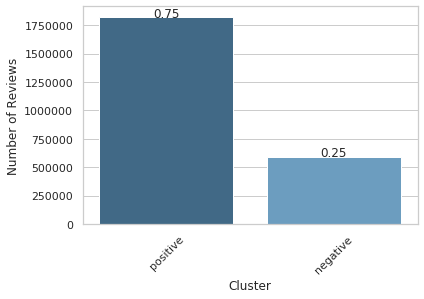

<Figure size 432x288 with 0 Axes>

In [0]:
ax = sns.barplot(x="Cluster", y="Number of Reviews", data=sent_count,palette="Blues_d")
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/len(df_rating)),
            ha="center")
plt.show()
plt.draw()
    
plt.savefig('/content/drive/My Drive/Text Mining Project/dumps&images/count_cluster.png')

In [0]:
cluster_df['Cluster'].value_counts()

1    1824723
0     594002
Name: Cluster, dtype: int64